In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/codealpha-handwriting-recognition/emnist-letters-mapping.txt
/kaggle/input/codealpha-handwriting-recognition/emnist-letters-test.csv
/kaggle/input/codealpha-handwriting-recognition/emnist-mnist-mapping.txt
/kaggle/input/codealpha-handwriting-recognition/emnist-digits-train.csv
/kaggle/input/codealpha-handwriting-recognition/emnist-bymerge-mapping.txt
/kaggle/input/codealpha-handwriting-recognition/emnist-balanced-train.csv
/kaggle/input/codealpha-handwriting-recognition/emnist-digits-test.csv
/kaggle/input/codealpha-handwriting-recognition/emnist-balanced-test.csv
/kaggle/input/codealpha-handwriting-recognition/emnist-mnist-test.csv
/kaggle/input/codealpha-handwriting-recognition/emnist-letters-train.csv
/kaggle/input/codealpha-handwriting-recognition/emnist-byclass-train.csv
/kaggle/input/codealpha-handwriting-recognition/emnist-bymerge-test.csv
/kaggle/input/codealpha-handwriting-recognition/emnist-balanced-mapping.txt
/kaggle/input/codealpha-handwriting-recognition/emn

In [2]:
# Cell 1 — install compatible protobuf
!pip install -q protobuf==3.20.3
!pip install -q --upgrade googleapis-common-protos
print("Installed protobuf==3.20.3 — now restart the runtime (next cell will do that).")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.9 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptograp

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths (based on your dataset)
train_path = "/kaggle/input/codealpha-handwriting-recognition/emnist-balanced-train.csv"
test_path = "/kaggle/input/codealpha-handwriting-recognition/emnist-balanced-test.csv"

# Reading CSV files
train_df = pd.read_csv(train_path, header=None)
test_df = pd.read_csv(test_path, header=None)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Split labels and images
y_train = train_df.iloc[:, 0].values
X_train = train_df.iloc[:, 1:].values

y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values

# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape into 28x28 grayscale
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


Train shape: (112800, 785)
Test shape: (18800, 785)
X_train: (112800, 28, 28, 1)
X_test: (18800, 28, 28, 1)


In [4]:
mapping_path = "/kaggle/input/codealpha-handwriting-recognition/emnist-balanced-mapping.txt"

mapping = {}
with open(mapping_path, "r") as f:
    for line in f:
        key, value = line.split()
        mapping[int(key)] = chr(int(value))

print("Total classes:", len(mapping))


Total classes: 47


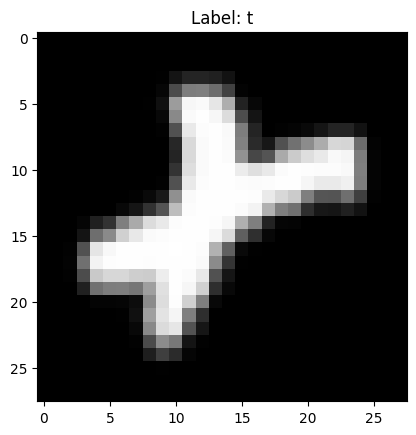

In [5]:
index = 10
plt.imshow(X_train[index].reshape(28,28), cmap='gray')
plt.title("Label: " + mapping[y_train[index]])
plt.show()


In [6]:
# Cell A - imports & hyperparameters
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report

# Hyperparameters
BATCH_SIZE = 128
EPOCHS = 20
IMG_SHAPE = (28,28,1)
MODEL_OUTPATH = "/kaggle/working/emnist_balanced_cnn.h5"


2025-11-26 21:31:51.982313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764192712.369932      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764192712.500743      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
import tensorflow as tf

print("TF Version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

# Test model
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Input((28,28,1)),
    layers.Conv2D(8, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

print("\nModel Summary:")
model.summary()

import numpy as np
x = np.random.rand(1, 28, 28, 1).astype("float32")
y = model.predict(x)
print("\nForward pass output shape:", y.shape)


TF Version: 2.18.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


I0000 00:00:1764192732.971829      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764192732.972514      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        54,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,170 (211.60 KB)

 Trainable params: 54,170 (211.60 KB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1764192734.900078     137 service.cc:148] XLA service 0x7aef4c00c3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764192734.901236     137 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764192734.901257     137 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764192735.050873     137 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Forward pass output shape: (1, 10)


I0000 00:00:1764192736.416692     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np, os

# Use MirroredStrategy to use both GPUs
strategy = tf.distribute.MirroredStrategy()
print("Num devices:", strategy.num_replicas_in_sync)
print("Devices:", tf.config.list_physical_devices('GPU'))

# Hyperparams
BATCH_SIZE = 256                # larger batch because two GPUs
GLOBAL_BATCH_SIZE = BATCH_SIZE
EPOCHS = 20
MODEL_OUTPATH = "/kaggle/working/emnist_balanced_cnn.h5"

def build_cnn(input_shape=(28,28,1), num_classes=47):
    # Small, effective CNN
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create model within strategy scope
num_classes = len(np.unique(y_train))
with strategy.scope():
    model = build_cnn(input_shape=X_train.shape[1:], num_classes=num_classes)

model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Num devices: 2
Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 47)             │        12,079 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 881,551 (3.36 MB)

 Trainable params: 880,847 (3.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [11]:
# Check label ranges to see if labels start at 1 (common in EMNIST)
import numpy as np
print("y_train min,max:", np.min(y_train), np.max(y_train))
print("y_test  min,max:", np.min(y_test),  np.max(y_test))
print("unique count (train):", len(np.unique(y_train)))


y_train min,max: 0 46
y_test  min,max: 0 46
unique count (train): 47


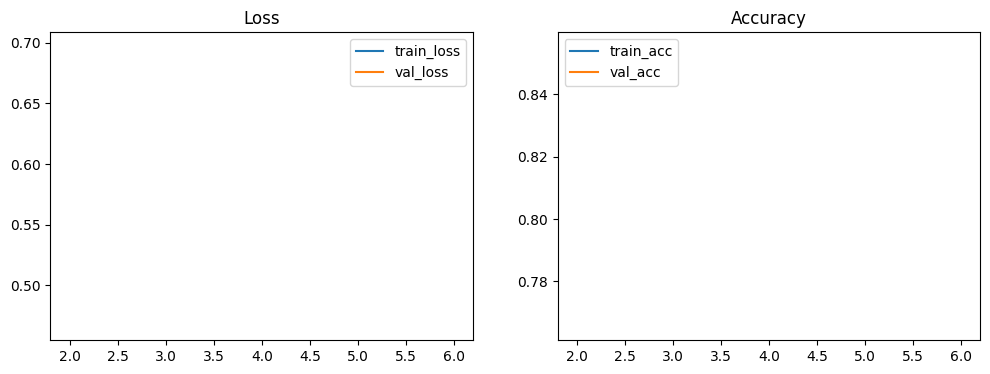

Test loss: nan | Test accuracy: nan


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Plot history
def plot_history(history):
    h = history.history
    epochs = range(1, len(h['loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train_loss')
    plt.plot(epochs, h['val_loss'], label='val_loss')
    plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2)
    plt.plot(epochs, h['accuracy'], label='train_acc')
    plt.plot(epochs, h['val_accuracy'], label='val_acc')
    plt.legend(); plt.title("Accuracy")
    plt.show()

plot_history(history)

# Load best model (checkpoint)
if os.path.exists(MODEL_OUTPATH):
    model = tf.keras.models.load_model(MODEL_OUTPATH)
    print("Loaded best model from", MODEL_OUTPATH)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")


In [12]:
import numpy as np, sys

def check_array(name, arr):
    print(f"{name}: dtype={arr.dtype}, shape={arr.shape}, min={np.nanmin(arr)}, max={np.nanmax(arr)}, mean={np.nanmean(arr)}")
    n_nan = np.isnan(arr).sum()
    n_inf = np.isinf(arr).sum()
    print(f"  NaNs: {n_nan}, Infs: {n_inf}")
    return n_nan, n_inf

# Flatten pixel arrays for range checks
_nnan, _ninf = check_array("X_train", X_train)
_nnan, _ninf = check_array("X_test", X_test)
_nnan, _ninf = check_array("y_train", y_train)
_nnan, _ninf = check_array("y_test", y_test)

# Quick check individual values outside [0,1] for images
bad_min = np.min(X_train) < 0.0
bad_max = np.max(X_train) > 1.0
print("Image values outside [0,1]? min<0:", bad_min, " max>1:", bad_max)

# Also check a small sample of labels validity
unique_labels = np.unique(y_train)
print("Unique labels sample:", unique_labels[:10], " count:", len(unique_labels))
if np.any(unique_labels < 0) or np.any(unique_labels >= len(mapping)):
    print("WARNING: label index out-of-range for mapping")


X_train: dtype=float64, shape=(112800, 28, 28, 1), min=0.0, max=1.0, mean=0.17510417052459276
  NaNs: 0, Infs: 0
X_test: dtype=float64, shape=(18800, 28, 28, 1), min=0.0, max=1.0, mean=0.17552242279890676
  NaNs: 0, Infs: 0
y_train: dtype=int64, shape=(112800,), min=0, max=46, mean=23.0
  NaNs: 0, Infs: 0
y_test: dtype=int64, shape=(18800,), min=0, max=46, mean=23.0
  NaNs: 0, Infs: 0
Image values outside [0,1]? min<0: False  max>1: False
Unique labels sample: [0 1 2 3 4 5 6 7 8 9]  count: 47


In [13]:
# Convert images to float32 and ensure shapes are correct
import numpy as np, os
print("Before:", X_train.dtype, X_test.dtype)
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
print("After: ", X_train.dtype, X_test.dtype)

# Quick sanity stats again
print("X_train min,max,mean:", X_train.min(), X_train.max(), X_train.mean())
print("X_test  min,max,mean:", X_test.min(), X_test.max(), X_test.mean())


Before: float64 float64
After:  float32 float32
X_train min,max,mean: 0.0 1.0 0.17510413
X_test  min,max,mean: 0.0 1.0 0.17552243


In [15]:

# Convert images to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# Quick sanity check
print("X_train dtype, min, max, mean:", X_train.dtype, X_train.min(), X_train.max(), X_train.mean())
print("X_test  dtype, min, max, mean:", X_test.dtype, X_test.min(), X_test.max(), X_test.mean())
3

X_train dtype, min, max, mean: float32 0.0 1.0 0.17510413
X_test  dtype, min, max, mean: float32 0.0 1.0 0.17552243


3

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np

num_classes = 47  # from your dataset

# --- Step 1: Build the CNN model ---
def build_cnn(input_shape=(28,28,1), num_classes=47):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D((2,2)),
        layers.Dropout(0.2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn(input_shape=X_train.shape[1:], num_classes=num_classes)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,559 (1.67 MB)

 Trainable params: 436,111 (1.66 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
# Step 2: Split train/validation
VAL_FRAC = 0.1
n_val = int(len(X_train) * VAL_FRAC)
x_val, y_val = X_train[:n_val], y_train[:n_val]
x_tr, y_tr = X_train[n_val:], y_train[n_val:]
print("Train samples:", x_tr.shape[0], "Validation samples:", x_val.shape[0])


Train samples: 101520 Validation samples: 11280


In [18]:
# Step 3: Train the model
BATCH_SIZE = 128
EPOCHS = 15

cb_list = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint("/kaggle/working/emnist_cnn.h5", monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    x_tr, y_tr,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=cb_list,
    verbose=2
)


Epoch 1/15

Epoch 1: val_loss improved from inf to 1.04632, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 20s - 25ms/step - accuracy: 0.4502 - loss: 2.0707 - val_accuracy: 0.7185 - val_loss: 1.0463 - learning_rate: 1.0000e-04
Epoch 2/15

Epoch 2: val_loss improved from 1.04632 to 0.68158, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.6948 - loss: 1.0448 - val_accuracy: 0.8021 - val_loss: 0.6816 - learning_rate: 1.0000e-04
Epoch 3/15

Epoch 3: val_loss improved from 0.68158 to 0.55707, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 8ms/step - accuracy: 0.7605 - loss: 0.7994 - val_accuracy: 0.8301 - val_loss: 0.5571 - learning_rate: 1.0000e-04
Epoch 4/15

Epoch 4: val_loss improved from 0.55707 to 0.49279, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.7892 - loss: 0.6798 - val_accuracy: 0.8468 - val_loss: 0.4928 - learning_rate: 1.0000e-04
Epoch 5/15

Epoch 5: val_loss improved from 0.49279 to 0.44923, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8080 - loss: 0.6063 - val_accuracy: 0.8534 - val_loss: 0.4492 - learning_rate: 1.0000e-04
Epoch 6/15

Epoch 6: val_loss improved from 0.44923 to 0.42795, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8224 - loss: 0.5551 - val_accuracy: 0.8581 - val_loss: 0.4280 - learning_rate: 1.0000e-04
Epoch 7/15

Epoch 7: val_loss improved from 0.42795 to 0.39588, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8309 - loss: 0.5184 - val_accuracy: 0.8686 - val_loss: 0.3959 - learning_rate: 1.0000e-04
Epoch 8/15

Epoch 8: val_loss improved from 0.39588 to 0.38795, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8376 - loss: 0.4904 - val_accuracy: 0.8668 - val_loss: 0.3879 - learning_rate: 1.0000e-04
Epoch 9/15

Epoch 9: val_loss improved from 0.38795 to 0.36553, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8446 - loss: 0.4677 - val_accuracy: 0.8747 - val_loss: 0.3655 - learning_rate: 1.0000e-04
Epoch 10/15

Epoch 10: val_loss improved from 0.36553 to 0.36264, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8496 - loss: 0.4482 - val_accuracy: 0.8756 - val_loss: 0.3626 - learning_rate: 1.0000e-04
Epoch 11/15

Epoch 11: val_loss improved from 0.36264 to 0.35230, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8542 - loss: 0.4326 - val_accuracy: 0.8792 - val_loss: 0.3523 - learning_rate: 1.0000e-04
Epoch 12/15

Epoch 12: val_loss improved from 0.35230 to 0.34681, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8590 - loss: 0.4176 - val_accuracy: 0.8797 - val_loss: 0.3468 - learning_rate: 1.0000e-04
Epoch 13/15

Epoch 13: val_loss improved from 0.34681 to 0.33931, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8601 - loss: 0.4077 - val_accuracy: 0.8825 - val_loss: 0.3393 - learning_rate: 1.0000e-04
Epoch 14/15

Epoch 14: val_loss improved from 0.33931 to 0.33481, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8644 - loss: 0.3954 - val_accuracy: 0.8832 - val_loss: 0.3348 - learning_rate: 1.0000e-04
Epoch 15/15

Epoch 15: val_loss improved from 0.33481 to 0.32588, saving model to /kaggle/working/emnist_cnn.h5


794/794 - 6s - 7ms/step - accuracy: 0.8663 - loss: 0.3869 - val_accuracy: 0.8883 - val_loss: 0.3259 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.


In [19]:
# Step 4: Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", test_loss, "Test accuracy:", test_acc)


Test loss: 0.34498849511146545 Test accuracy: 0.8806914687156677


588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


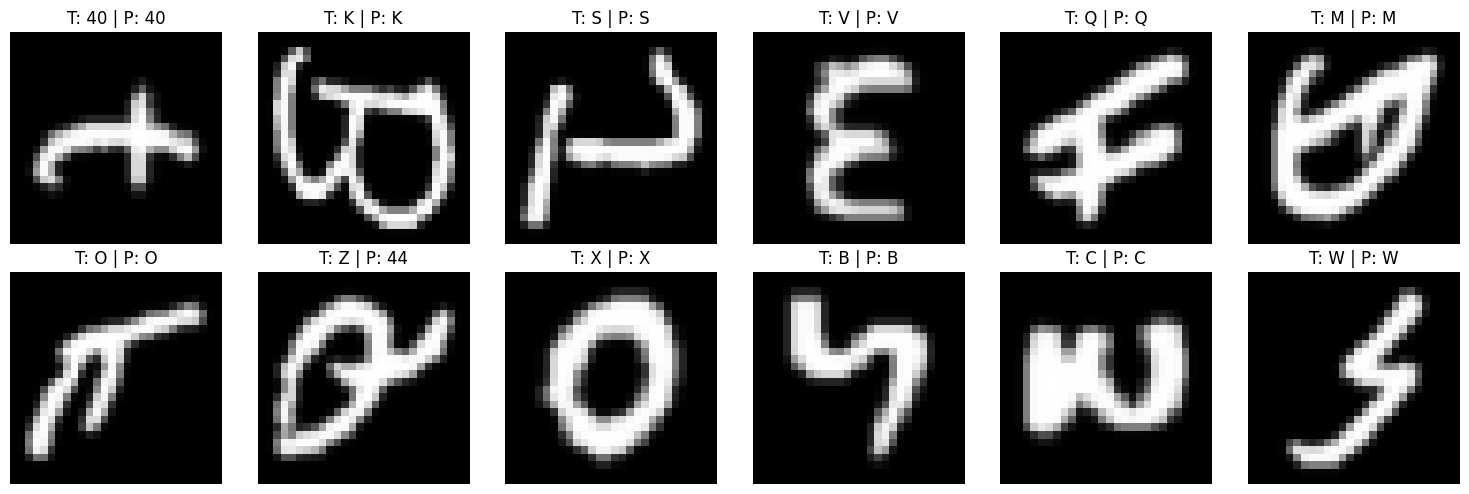

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Load the mapping
mapping_file = '/kaggle/input/codealpha-handwriting-recognition/emnist-letters-mapping.txt'
mapping = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            class_idx, char_code = parts[:2]
            mapping[int(class_idx)] = chr(int(char_code))

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot random samples
num_samples = 12
indices = np.random.choice(len(X_test), num_samples, replace=False)

plt.figure(figsize=(15,5))
for i, idx in enumerate(indices):
    img = X_test[idx].squeeze()
    true_label = mapping.get(y_test[idx], y_test[idx])  # fallback to integer if not in mapping
    pred_label = mapping.get(y_pred[idx], y_pred[idx])
    
    plt.subplot(2, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T: {true_label} | P: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


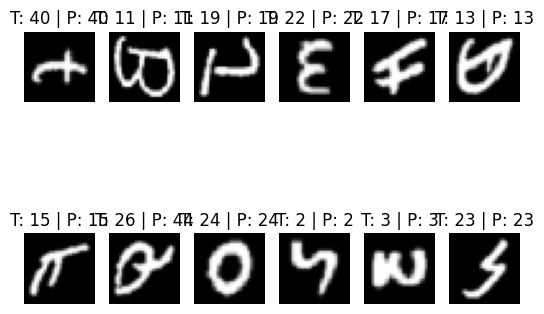

In [23]:
for i, idx in enumerate(indices):
    img = X_test[idx].squeeze()
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    
    plt.subplot(2, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T: {true_label} | P: {pred_label}")
    plt.axis('off')


In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# y_pred_probs from model
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Accuracy ---
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%")

# --- Optional: Detailed classification report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Optional: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Test Accuracy: 88.07%

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       400
           1       0.58      0.64      0.61       400
           2       0.92      0.89      0.90       400
           3       0.99      0.98      0.99       400
           4       0.94      0.91      0.93       400
           5       0.97      0.84      0.90       400
           6       0.91      0.96      0.93       400
           7       0.97      0.98      0.98       400
           8       0.90      0.96      0.93       400
           9       0.69      0.80      0.74       400
          10       0.96      0.97      0.97       400
          11       0.98      0.95      0.96       400
          12       0.94      0.96      0.95       400
          13       0.93      0.89      0.91       400
          14       0.98      0.97      0.98       400
          15       0.71      0.56      0.62       400
          16       0.96      0.93  